# Discrete PI with ITAE parameters
This notebook reproduces Figure 17.10 in Seborg _et al_ and also goes a little further

In [1]:
from tbcontrol import blocksim, fopdtitae

In [2]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def limit(u, umin, umax):
    return max(umin, min(u, umax))

In [4]:
class DiscretePI(blocksim.Block):
    def __init__(self, name, inputname, outputname, K, tau_I, deltat, umin=-numpy.inf, umax=numpy.inf):
        super().__init__(name, inputname, outputname)

        self.K = K
        self.tau_I = tau_I
        self.deltat = deltat
        self.umin = umin
        self.umax = umax
        self.reset()

    def reset(self):
        self.state = 0
        self.output = 0
        self.eint = 0
        self.nextsample = 0
        
    def change_input(self, t, e):
        if t >= self.nextsample:
            self.eint += e*self.deltat
            self.output = self.K*(e + self.eint/self.tau_I)
            self.nextsample += self.deltat
            
        return limit(self.output, self.umin, self.umax)
    
    def change_state(self, x):
        self.state = x
        
    def derivative(self, e):
        return 0

In [5]:
class DiscretePI_vel(DiscretePI):
    def reset(self):
        self.state = 0
        self.output = 0
        self.e_k_1 = 0
        self.nextsample = 0
        
    def change_input(self, t, e_k):
        if t >= self.nextsample:
            self.output += self.K*((e_k - self.e_k_1) + self.deltat/self.tau_I*e_k)
            self.output = limit(self.output, self.umin, self.umax)
            
            self.e_k_1 = e_k
            self.nextsample += self.deltat

        return self.output

The system is

$$ G = G_v G_p G_m = \frac{-20 e^{-s}}{5s + 1} = \frac{K_p e^{-\theta s}}{\tau_p s + 1}$$

It is not explicitly stated in the example, but $G_d = G$ is assumed.

In [6]:
Kp = -20
taup = 5
theta = 1

In [7]:
G = blocksim.LTI('G', 'u', 'yu',
                 Kp, [taup, 1], theta)

In [8]:
Gd = blocksim.LTI('G', 'd', 'yd',
                  Kp, [taup, 1], theta)

Note we can't just do `G = Gd` because we need new names and a new state for the block.

In [9]:
sums = {'y': ('+yu', '+yd'),
        'e': ('-y', '+r')}

In [10]:
inputs = {'r': lambda t: 0,
          'd': lambda t: 1}

In [11]:
ts = numpy.linspace(0, 15, 2000)

In [12]:
deltats = [0.05, 0.25, 0.5, 1]

# Reconstruction
Here is the direct reconstruction of Figure 11.10. Turns out they use a continuous PI controller with the parameters for a discrete controller.

In [13]:
def simulate(controller, discrete=True, umin=-numpy.inf, umax=numpy.inf):
    fig, (uaxis, yaxis) = plt.subplots(2, 1, figsize=(5, 10))
    for deltat in deltats:
        Kc, tau_I = fopdtitae.parameters(Kp, taup, theta + deltat/2)
        Gc = controller('Gc', 'e', 'u',
                        Kc, tau_I, 
                        *((deltat, umin, umax) if discrete else ()))
        diagram = blocksim.Diagram([G, Gd, Gc], sums, inputs)
        outputs = diagram.simulate(ts)
        uaxis.plot(ts, outputs['u'])
        yaxis.plot(ts, outputs['y'], label='∆t={}'.format(deltat))
    uaxis.set_ylabel('u')
    yaxis.set_ylabel('y')
    yaxis.plot(ts, outputs['r'], label='r')
    yaxis.legend()

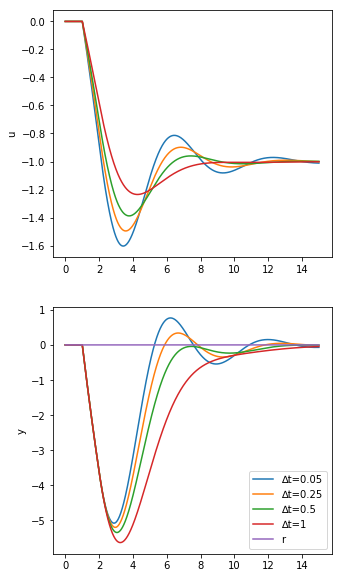

In [14]:
simulate(blocksim.PI, discrete=False)

# Discrete responses

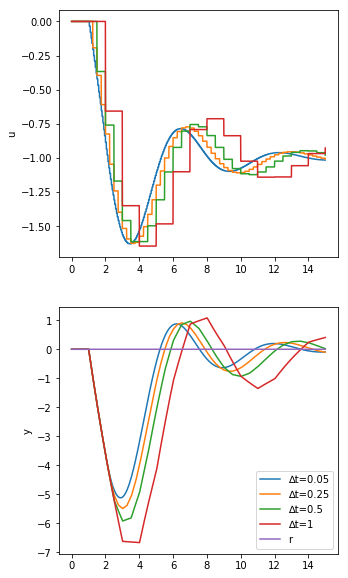

In [15]:
simulate(DiscretePI)

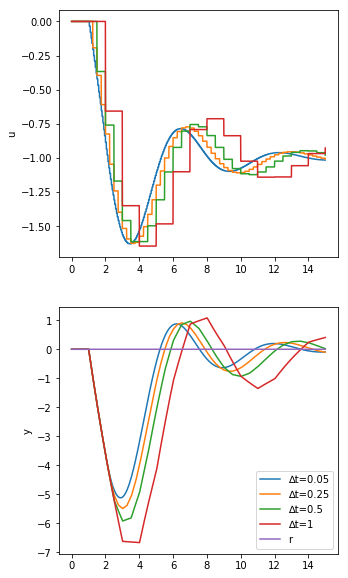

In [16]:
simulate(DiscretePI_vel)

This looks different from the given figure, but the position form and velocity form look identical. Note that the analog PI controller gets better results than the digital approximations with the same controller parameters.

# With output limits
Now, let's include limiting behaviour

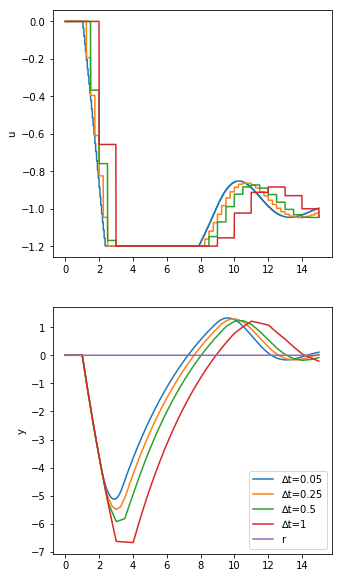

In [17]:
simulate(DiscretePI, umin=-1.2, umax=0)

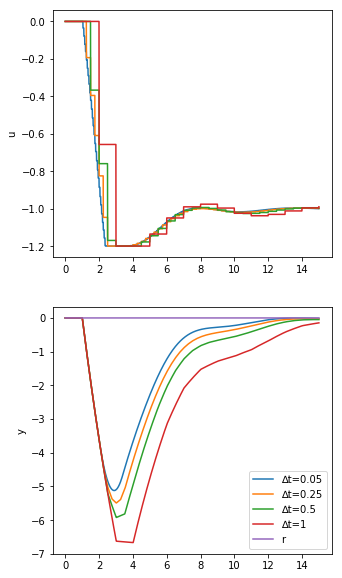

In [18]:
simulate(DiscretePI_vel, umin=-1.2, umax=0)

The windup on the position form PID is very clear.

# With setpoint tracking

Let's include setpoint tracking as well.

In [19]:
def step(tstep, start=0, stop=1):
    def f(t):
        if t <= tstep:
            return start
        else:
            return stop
    return f

In [20]:
inputs['r'] = step(0)
inputs['d'] = step(15)

In [21]:
ts = numpy.linspace(0, 30, 2000)

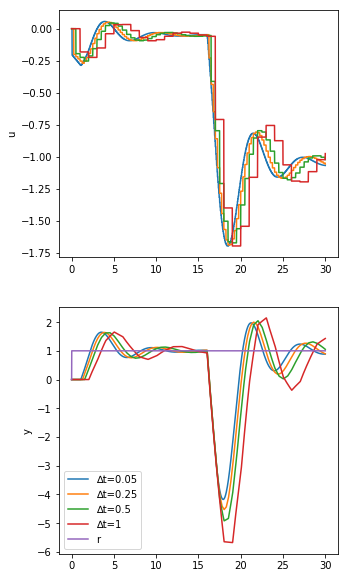

In [22]:
simulate(DiscretePI)